In [ ]:
! pip install pandas
! pip install numpy
! pip install scikit-learn
! pip install matplotlib
! pip install seaborn

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Datasets/movies_metadata.csv", low_memory=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
movies = df[['title', 'genres', 'vote_average', 'popularity']].copy()

In [ ]:
movies = movies.dropna(subset=['genres', 'vote_average', 'popularity'])

In [ ]:
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

movies['genre_list'] = movies['genres'].apply(parse_genres)

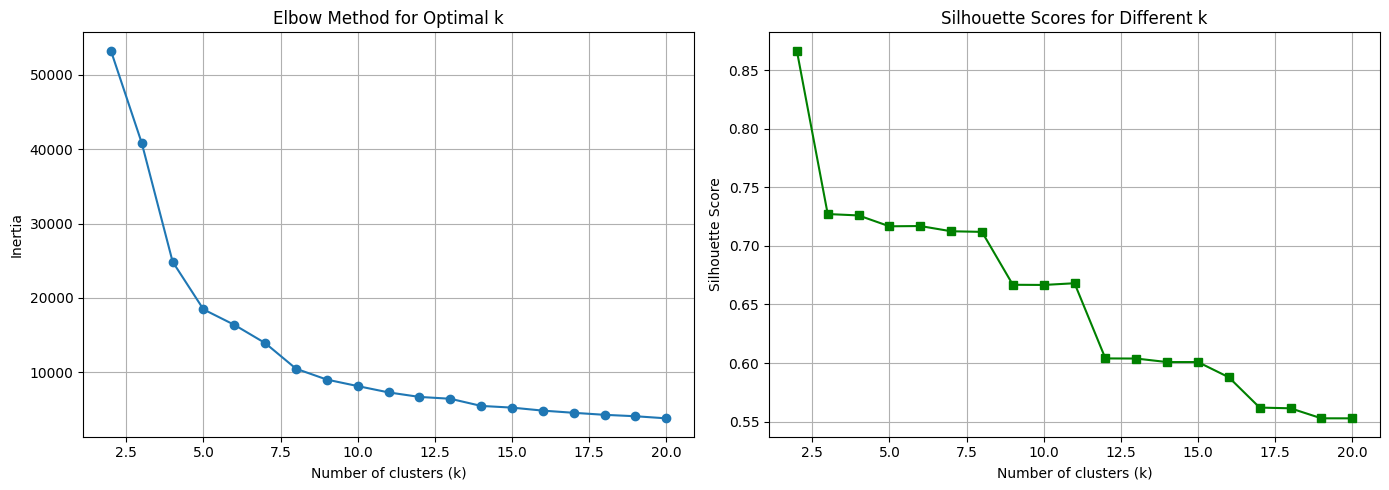

In [ ]:
inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

<ipython-input-15-0e7392235ea7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


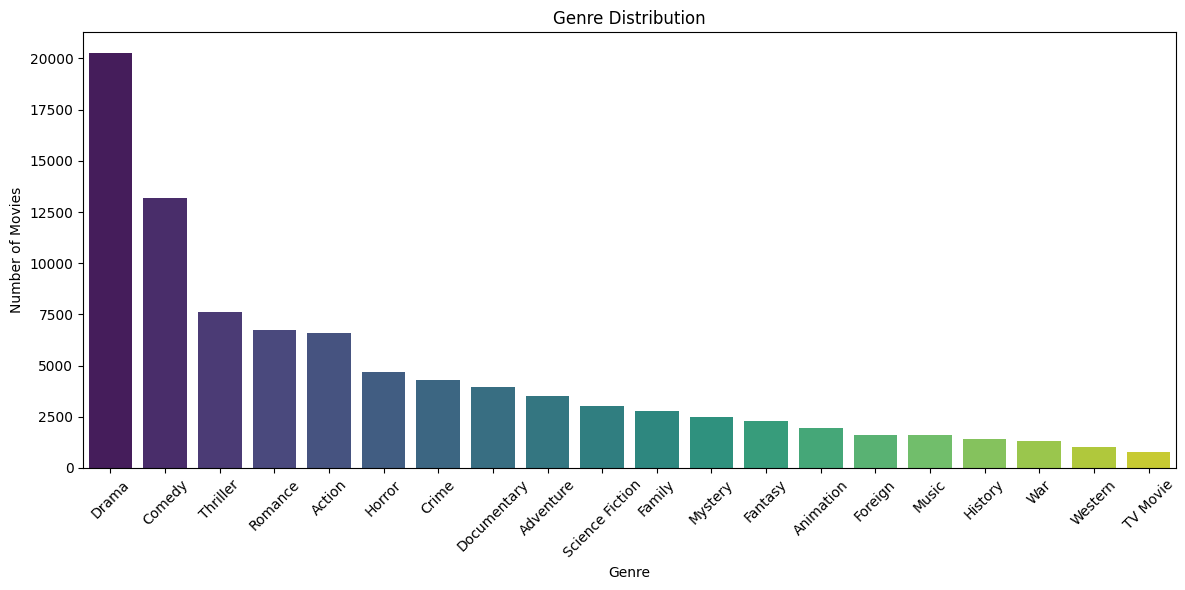

In [ ]:
genre_counts = movies['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [ ]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(movies['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

In [ ]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(movies[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])

In [ ]:
final_features = pd.concat([genre_df, scaled_df], axis=1)

<ipython-input-24-ab167796f9bc>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=movies['cluster'], palette='coolwarm')


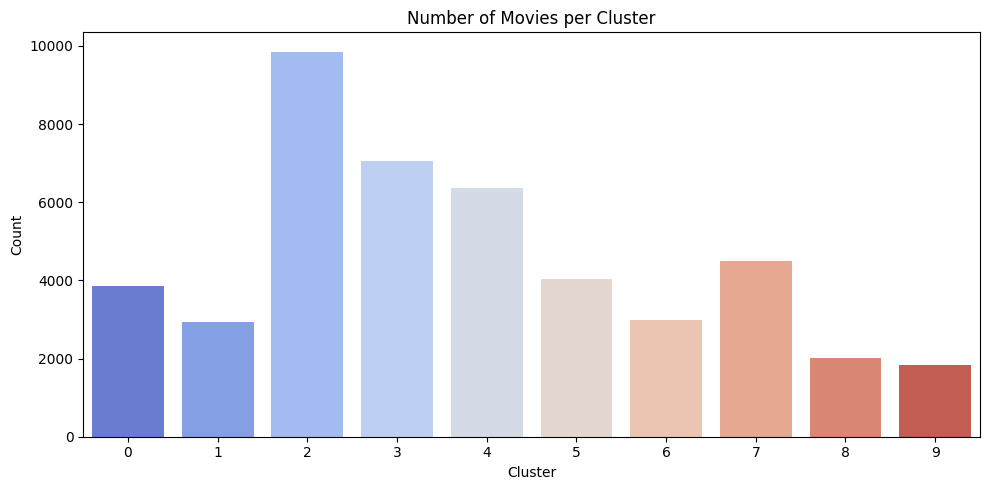

In [ ]:
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
movies['cluster'] = kmeans.fit_predict(final_features)

plt.figure(figsize=(10, 5))
sns.countplot(x=movies['cluster'], palette='coolwarm')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [ ]:
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies based on genre, popularity, and rating using clustering.

    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.

    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster.
    """
    target = movies[movies['title'].str.lower() == movie_title.lower()]

    if target.empty:
        return f" Movie titled '{movie_title}' not found in dataset."

    cluster_id = target['cluster'].values[0]

    similar_movies = movies[(movies['cluster'] == cluster_id) &
                            (movies['title'].str.lower() != movie_title.lower())]

    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)

print(" Recommended movies similar to 'Taxi Driver':")
print(recommend_movies("Boomerang", n=5))

 Recommended movies similar to 'Taxi Driver':
                               title  vote_average popularity
27295                 The Little Hut          10.0   0.883862
41036             A Kiss at Midnight          10.0   0.631015
16681  The Misadventures of Margaret          10.0   0.196886
41709                   The Bachelor          10.0   0.187552
24214      Looking for Maria Sanchez          10.0   0.122935
